In [1]:
import numpy as np
import pandas as pd
from model.autoencoder import AutoEncoder
from model.vae import aligned_vae, vae
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import diffusion_dist as diff
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from dataset import *
import scipy
import math

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
pd_atac = pd.read_csv('./data/expr_rna_500.csv', index_col=0)
pd_rna = pd.read_csv('./data/expr_rna_500.csv', index_col=0)
atac = pd_atac.to_numpy()
rna = pd_rna.to_numpy()

In [3]:
rna.shape

(3094, 499)

In [2]:
def pairwise_distance(x):
    x_norm = (x**2).sum(1).view(-1, 1)
    y_norm = x_norm.view(1, -1)
    dist = x_norm + y_norm - 2.0 * torch.mm(x, torch.transpose(x, 0, 1))
    dist = torch.sqrt(dist)
    return dist 

# Similarity matrix
Note that for distance calculation, dimension reduction is necessary as raw data is too noisy
## Diffusion map distance

In [4]:
pca = PCA(n_components=30)
# atac_lsi = latent_semantic_indexing(atac, k = 30)
atac_pca = pca.fit_transform(atac)
rna_pca = pca.fit_transform(np.log1p(rna))

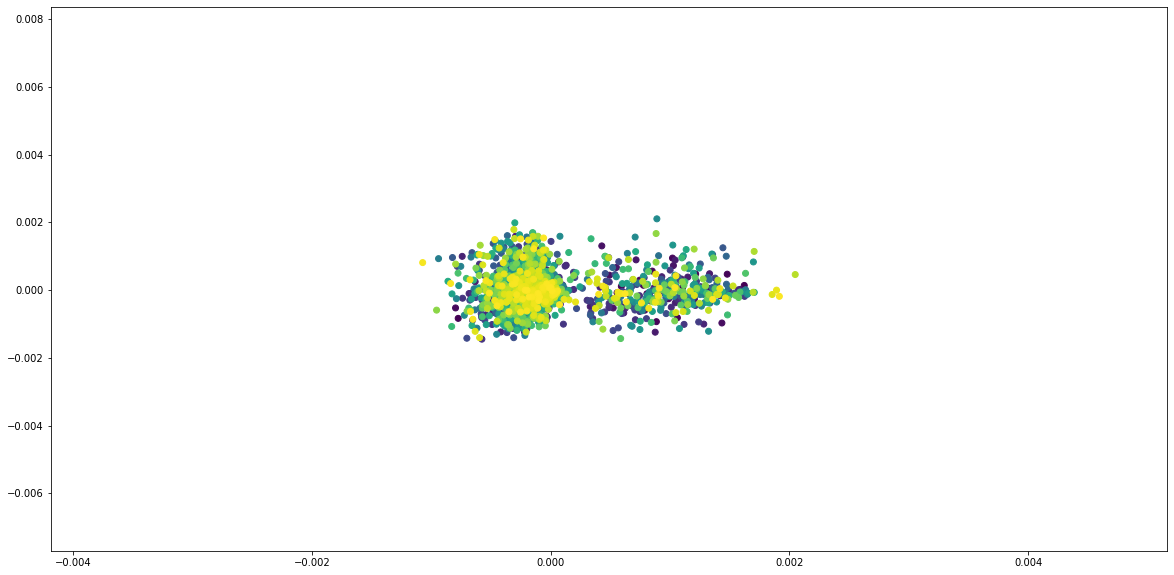

In [5]:
diffu_atac = diff.diffusion_map(atac_pca, n_eign = 10, alpha = 100, diffusion_time = 5)
diff_sim_atac = diff.diffusion_similarity(diffu_atac)
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot()
ax.scatter(diffu_atac[:,2], diffu_atac[:,3], c=np.arange(atac.shape[0]))

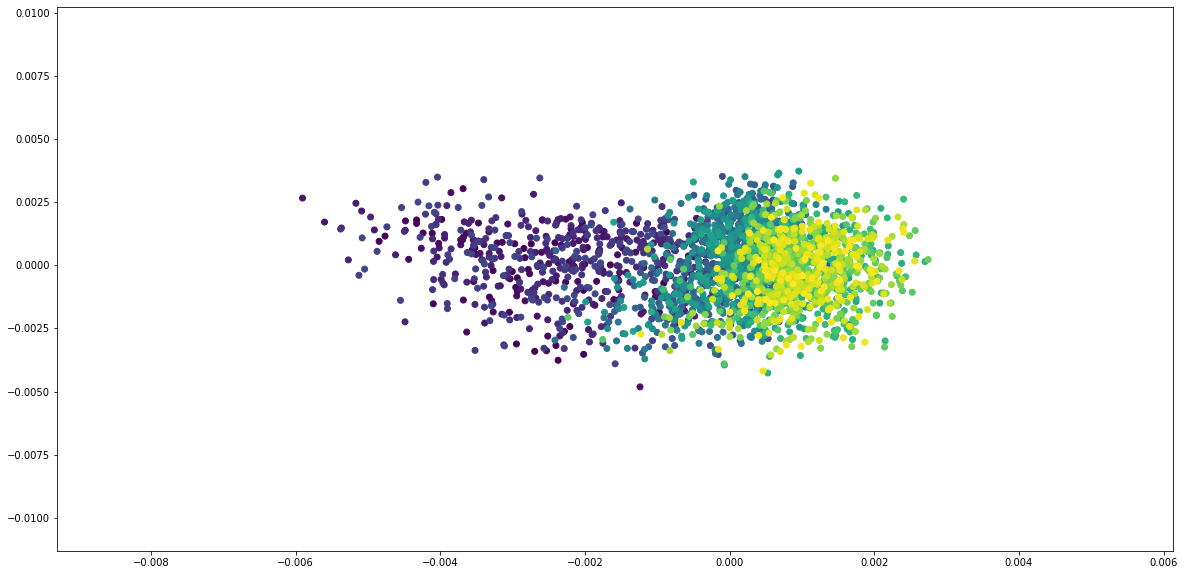

In [6]:
diffu = diff.diffusion_map(rna_pca, n_eign = 10, alpha = 20, diffusion_time = 5)
diff_sim_rna = diff.diffusion_similarity(diffu)
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot()
ax.scatter(diffu[:,2], diffu[:,4], c=np.arange(rna.shape[0]))


In [7]:
# normalize both matrices for inner product loss
diff_sim_atac = torch.FloatTensor(diff_sim_atac).to(device)
diff_sim_rna = torch.FloatTensor(diff_sim_rna).to(device)
diff_sim_atac = diff_sim_atac / torch.norm(diff_sim_atac, p = 'fro')
diff_sim_rna = diff_sim_rna / torch.norm(diff_sim_rna, p = 'fro')

In [8]:
# pca calculated internally, no need to do pca before
DPT_atac = diff.DPT_similarity(atac)
DPT_rna = diff.DPT_similarity(rna)

# normalize both matrices for inner product loss
DPT_atac = torch.FloatTensor(DPT_atac).to(device)
DPT_rna = torch.FloatTensor(DPT_rna).to(device)
DPT_atac = DPT_atac / torch.norm(DPT_atac, p = 'fro')
DPT_rna = DPT_rna / torch.norm(DPT_rna, p = 'fro')

In [9]:
from sklearn.neighbors import kneighbors_graph
x = kneighbors_graph(atac, 3)

In [10]:
x.toarray().sum()

7923.0

In [9]:
def dist_loss(recon_atac, recon_rna, atac, rna, z, diff_atac, diff_rna, lamb, lamb_var, lamb_atac, dist_loss_type = None):
    loss_recon_rna = torch.sqrt(F.mse_loss(recon_rna, rna))
    loss_recon_atac = torch.sqrt(lamb_atac * F.mse_loss(recon_atac, atac))

    # loss_variance = - lamb_var * (torch.sum((z[:,0] - torch.mean(z[:,0])) ** 2) + torch.sum((z[:,1] - torch.mean(z[:,1])) ** 2))

    # cosine similarity loss, don't forget to normalize the matrix before calculate inner product
    if dist_loss_type == "cosine":
        # diff_atac and diff_rna are only constant, but better to be normalized
        Sim = pairwise_distance(z)
        # normalize latent similarity matrix
        Sim = Sim / torch.norm(Sim, p='fro')

        # inner product loss, maximize, so add negative before, in addition, make sure those two values are normalized, with norm 1
        loss_dist_atac = - lamb * torch.sum(diff_atac * Sim)
        loss_dist_rna = - lamb * torch.sum(diff_rna * Sim)

    # pearson correlationship
    elif dist_loss_type == "pearson":
        Sim = pairwise_distance(z)
        Vs = Sim - torch.mean(Sim)

        Vd_atac = diff_atac - torch.mean(diff_atac)
        Vd_rna = diff_rna - torch.mean(diff_rna)

        # maximize correlationship
        loss_dist_atac = - lamb * torch.sum(Vs * Vd_atac) / (torch.sqrt(torch.sum(Vs ** 2)) * torch.sqrt(torch.sum(Vd_atac ** 2)))
        loss_dist_rna = - lamb * torch.sum(Vs * Vd_rna) / (torch.sqrt(torch.sum(Vs ** 2)) * torch.sqrt(torch.sum(Vd_rna ** 2)))
    
    # mse loss
    elif dist_loss_type == "mse":
        loss_dist_atac = lamb * F.mse_loss(diff_atac.reshape(-1), pairwise_distance(z).reshape(-1))
        loss_dist_rna = lamb * F.mse_loss(diff_rna.reshape(-1), pairwise_distance(z).reshape(-1))

    else:
        loss_dist_atac = loss_dist_rna = loss_recon_atac

    # assert(torch.sum(torch.isnan(loss_dist_atac)) == 0)
    # loss = loss_recon_rna + loss_recon_atac + loss_dist_atac + loss_dist_rna
    loss =  loss_recon_rna + loss_recon_atac
    return loss, loss_recon_rna, loss_recon_atac,  loss_dist_atac,  loss_dist_rna

In [10]:
def train_ae(model, data_loader, lamb = 10, lamb_var = 0.1, lamb_atac = 50, similarity = None):
    model.train()

    total_loss = 0
    total_loss_recon_rna = total_loss_recon_atac = 0
    total_loss_dist_atac = total_loss_dist_rna = 0
    total_loss_var = 0
    for data in data_loader:
        optimizer.zero_grad()
        batch_atac = data['ATAC'].to(device)
        batch_rna = data['RNA'].to(device)
        recon_atac, recon_rna, z, latent_atac, latent_rna = model(batch_atac, batch_rna)
        # print(torch.sum(torch.isnan(recon_atac)))
        # print(torch.sum(torch.isnan(recon_rna)))

        if similarity == "DPT":
            batch_diff_atac = DPT_atac[data['index'], :][:, data['index']]
            batch_diff_rna = DPT_rna[data['index'], :][:, data['index']]           
        if similarity == "diffusion map":
            batch_diff_atac = diff_sim_atac[data['index'], :][:, data['index']]
            batch_diff_rna = diff_sim_rna[data['index'], :][:, data['index']]
        else:
            batch_diff_atac = batch_diff_rna = None

        loss = dist_loss(recon_atac, recon_rna, batch_atac, batch_rna, z, batch_diff_atac, batch_diff_rna, lamb = lamb, lamb_var = lamb_var, lamb_atac = lamb_atac, dist_loss_type= None)
        total_loss += loss[0]
        total_loss_recon_rna += loss[1]
        total_loss_recon_atac += loss[2]
        total_loss_dist_rna += loss[3]
        total_loss_dist_atac += loss[4]

        current_loss = loss[0]
        current_loss.backward()
        optimizer.step()

    return total_loss.item() / len(data_loader), total_loss_recon_rna.item() / len(data_loader), total_loss_recon_atac.item() / len(data_loader), \
 total_loss_dist_rna.item() / len(data_loader), total_loss_dist_atac.item() / len(data_loader)

In [11]:
def test(model, data_loader):
    for data in data_loader:
        recon_atac, recon_rna, z, latent_atac, latent_rna = model(torch.FloatTensor(data['ATAC']).to(device), data['RNA'].to(device))
    z = z.detach().cpu().numpy()
    # atac_loss = F.mse_loss(torch.FloatTensor(atac).to(device), recon_atac).item()
    # rna_loss = F.mse_loss(torch.FloatTensor(rna).to(device), recon_rna).item()
    return z, recon_atac, recon_rna

## AutoEncoder
Diffusion map as similarity matrix

In [12]:
dataset = scDataset_500()
testset = testDataset()

In [13]:
data_loader = DataLoader(dataset, shuffle=True, batch_size=20)
data_loader_test = DataLoader(dataset, batch_size=len(dataset),shuffle=False)

In [14]:
for data in data_loader:
    print(np.sort(data['RNA']))
    break

[[ 0.        0.        0.       ... 18.872427 18.872427 25.016232]
 [ 0.        0.        0.       ... 18.080397 19.290346 35.362007]
 [ 0.        0.        0.       ... 24.786285 26.104853 27.26964 ]
 ...
 [ 0.        0.        0.       ... 17.436237 17.436237 21.209618]
 [ 0.        0.        0.       ... 17.965895 19.508778 19.508778]
 [ 0.        0.        0.       ... 21.825602 23.459108 23.459108]]


In [15]:
model_ae = AutoEncoder(in_channels_atac=atac.shape[1], in_channels_rna=rna.shape[1], latent_channels_atac=32, latent_channels_rna=32, latent_channels_z=2, layer1_channels = 512, layer2_channels = 256).to(device)
optimizer = torch.optim.Adam(model_ae.parameters(), lr=1e-4, weight_decay=0.01)

for epoch in range(0, 81):

    loss, l1, l2, l3, l4 = train_ae(model_ae, data_loader, lamb = 0, lamb_atac = 0, similarity = None)
    if epoch % 10 == 0:
        log = "Epoch: {:03d}, Total loss: {:.5f}, Recon RNA loss: {:.5f}, Recon ATAC loss {:.5f}, Dist RNA loss {:.5f}, Dist ATAC loss {:.5f}"
        print(log.format(epoch, loss, l1, l2, l3, l4))

Epoch: 000, Total loss: nan, Recon RNA loss: 4.50246, Recon ATAC loss nan, Dist RNA loss nan, Dist ATAC loss nan
Epoch: 010, Total loss: nan, Recon RNA loss: 4.30539, Recon ATAC loss nan, Dist RNA loss nan, Dist ATAC loss nan
Epoch: 020, Total loss: nan, Recon RNA loss: 4.30420, Recon ATAC loss nan, Dist RNA loss nan, Dist ATAC loss nan
Epoch: 030, Total loss: nan, Recon RNA loss: 4.30574, Recon ATAC loss nan, Dist RNA loss nan, Dist ATAC loss nan
Epoch: 040, Total loss: nan, Recon RNA loss: 4.30466, Recon ATAC loss nan, Dist RNA loss nan, Dist ATAC loss nan
Epoch: 050, Total loss: nan, Recon RNA loss: 4.30477, Recon ATAC loss nan, Dist RNA loss nan, Dist ATAC loss nan
Epoch: 060, Total loss: nan, Recon RNA loss: 4.30442, Recon ATAC loss nan, Dist RNA loss nan, Dist ATAC loss nan
Epoch: 070, Total loss: nan, Recon RNA loss: 4.30352, Recon ATAC loss nan, Dist RNA loss nan, Dist ATAC loss nan
Epoch: 080, Total loss: nan, Recon RNA loss: 4.30378, Recon ATAC loss nan, Dist RNA loss nan, Di

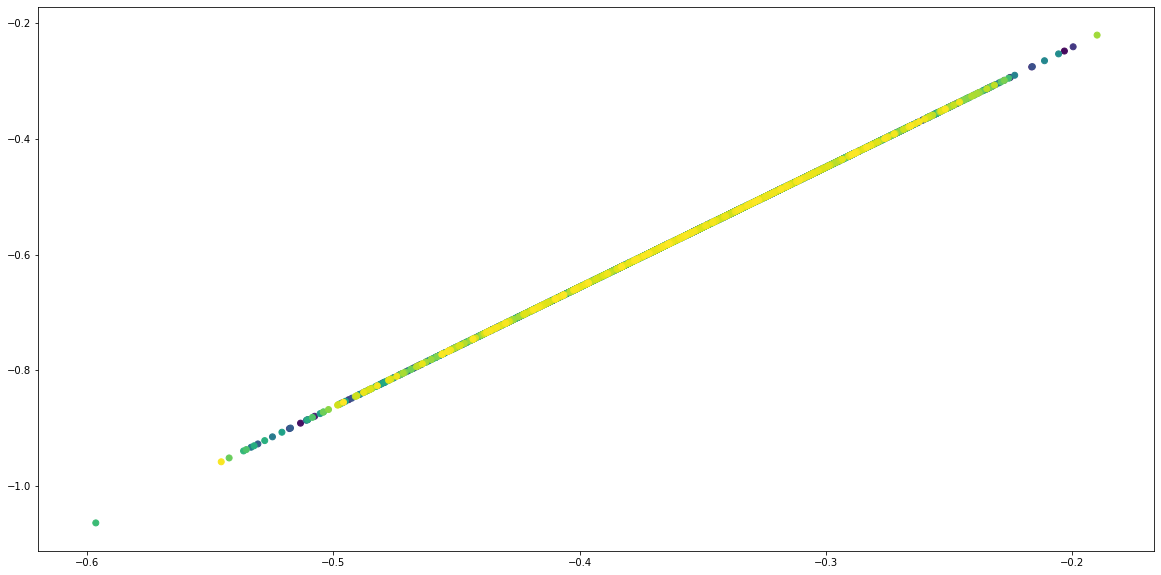

In [14]:
z, recon_atac, recon_rna = test(model_ae, data_loader_test)
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot()
ax.scatter(z[:,0], z[:,1], c=np.arange(rna.shape[0]))
# print("atac recon loss: ", atac_loss, "rna recon loss", rna_loss)

In [16]:
recon_rna

tensor([[0.0645, 0.1071, 0.0557,  ..., 0.4479, 0.0382, 0.0628],
        [0.0973, 0.1622, 0.0843,  ..., 0.6699, 0.0573, 0.0947],
        [0.0843, 0.1404, 0.0730,  ..., 0.5822, 0.0498, 0.0821],
        ...,
        [0.1081, 0.1803, 0.0938,  ..., 0.7431, 0.0636, 0.1052],
        [0.1048, 0.1747, 0.0909,  ..., 0.7205, 0.0617, 0.1020],
        [0.1380, 0.2305, 0.1199,  ..., 0.9456, 0.0810, 0.1343]],
       device='cuda:0', grad_fn=<AddmmBackward>)

In [15]:
np.sort(recon_rna.detach().cpu().numpy())

array([[0.03051908, 0.0321441 , 0.03231108, ..., 0.45916384, 0.48160225,
        0.5030002 ],
       [0.04577859, 0.0482127 , 0.04877935, ..., 0.69655   , 0.7257755 ,
        0.7612847 ],
       [0.03975385, 0.0418685 , 0.04227736, ..., 0.6028253 , 0.6293711 ,
        0.659309  ],
       ...,
       [0.0508115 , 0.05351243, 0.05421093, ..., 0.7748445 , 0.8063087 ,
        0.84647226],
       [0.04925893, 0.05187755, 0.05253537, ..., 0.7506924 , 0.7814659 ,
        0.82019335],
       [0.06472325, 0.06816182, 0.06922469, ..., 0.99126536, 1.0289168 ,
        1.0819446 ]], dtype=float32)

In [14]:
np.sort(rna)

array([[0.       , 0.       , 0.       , ..., 2.3744435, 2.6385841,
        2.6385841],
       [0.       , 0.       , 0.       , ..., 1.6353213, 1.7846218,
        1.8516681],
       [0.       , 0.       , 0.       , ..., 2.0290847, 2.1460476,
        2.2507515],
       ...,
       [0.       , 0.       , 0.       , ..., 1.8488533, 1.9802591,
        1.9802591],
       [0.       , 0.       , 0.       , ..., 1.9558363, 2.1752136,
        2.2691507],
       [0.       , 0.       , 0.       , ..., 1.6357734, 1.7288992,
        2.8203173]])

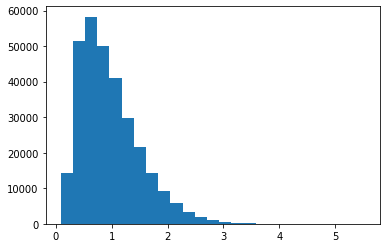

In [4]:
import matplotlib.pyplot as plt
x = rna[np.where(rna!=0)]
n, bins, patches = plt.hist(x, 25)

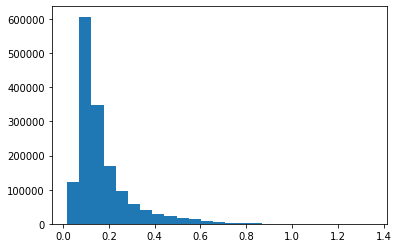

In [18]:
y = recon_rna.detach().cpu().numpy()
y = y[np.where(y!=0)]
n, bins, patches = plt.hist(y, 25)
plt.show()

In [3]:
datasymsim = symsimLinear()

Logarithmized X.


In [49]:
testset = testDataset()
dataset = scDataset_500()
data_loader = DataLoader(dataset, batch_size=64)
test_loader = DataLoader(dataset, batch_size=len(dataset))

In [50]:
for data in test_loader:
    print(data['RNA'].shape)
    break

torch.Size([3094, 499])


In [53]:
import torch.nn as nn
n_features = 784
encoder_h1 = nn.Linear(in_features=499, out_features=128)
encoder_h2 = nn.Linear(in_features=128, out_features= 64)
encoder_out = nn.Linear(in_features=64, out_features=32)
decoder_h1 = nn.Linear(in_features=32, out_features=64)
decoder_h2 = nn.Linear(in_features=64, out_features=128)
decoder_out = nn.Linear(in_features=128, out_features=499)

# return the model directly
ae_simple = nn.Sequential(encoder_h1, nn.LeakyReLU(negative_slope=0.2), encoder_h2, nn.LeakyReLU(negative_slope=0.2), encoder_out, nn.LeakyReLU(negative_slope=0.2), decoder_h1, nn.LeakyReLU(negative_slope=0.2), decoder_h2, nn.LeakyReLU(negative_slope=0.2), decoder_out).to(device)


In [56]:
optimizer = torch.optim.Adam(ae_simple.parameters(), lr=1e-5, weight_decay=0.01)

for epoch in range(0, 501):
    total_loss = 0
    for data in data_loader:
        optimizer.zero_grad()
        batch_rna = data['RNA'].to(device)
        recon = ae_simple(batch_rna)
        loss = torch.sqrt(F.mse_loss(recon, batch_rna))
        loss.backward()
        optimizer.step()
        total_loss += loss
    total_loss /= len(data_loader)
    if epoch % 10 == 0:
        log = "Epoch: {:03d}, Total loss: {:.5f}"
        print(log.format(epoch, total_loss))

Epoch: 000, Total loss: 4.30163
Epoch: 010, Total loss: 4.30132
Epoch: 020, Total loss: 4.30132
Epoch: 030, Total loss: 4.30132
Epoch: 040, Total loss: 4.30132
Epoch: 050, Total loss: 4.30132
Epoch: 060, Total loss: 4.30132
Epoch: 070, Total loss: 4.30132
Epoch: 080, Total loss: 4.30132
Epoch: 090, Total loss: 4.30132
Epoch: 100, Total loss: 4.30132
Epoch: 110, Total loss: 4.30132
Epoch: 120, Total loss: 4.30132
Epoch: 130, Total loss: 4.30132
Epoch: 140, Total loss: 4.30132
Epoch: 150, Total loss: 4.30132


KeyboardInterrupt: 

In [55]:

for data in test_loader:
    print(data['RNA'])
    print(ae_simple(data['RNA'].to(device)))
    # print(recon)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  3.4579,  0.0000,  ...,  3.4579,  0.0000,  3.4579],
        [ 0.0000,  0.0000,  0.0000,  ..., 10.6048,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  6.2440,  0.0000,  0.0000],
        [ 2.2355,  4.8629,  1.1801,  ..., 15.3308, 28.2032,  0.0000]])
tensor([[ 0.6919,  1.0228,  0.5853,  ...,  4.4260,  0.4472,  0.5886],
        [ 1.1642,  1.7243,  0.9882,  ...,  7.4352,  0.7520,  0.9908],
        [ 0.9692,  1.4348,  0.8219,  ...,  6.1931,  0.6262,  0.8247],
        ...,
        [ 1.3078,  1.9376,  1.1107,  ...,  8.3503,  0.8447,  1.1131],
        [ 1.2573,  1.8626,  1.0676,  ...,  8.0285,  0.8121,  1.0701],
        [ 1.7527,  2.5983,  1.4902,  ..., 11.1845,  1.1318,  1.4919]],
       device='cuda:0', grad_fn=<AddmmBackward>)


In [57]:
from model.saucie import *

In [59]:
CONFIG = { 
    'latent_size': 2, # embedding dimension.
    'lambda_b': 0, # regularization rate of MMD loss.
    'lambda_c': 0, # reg. rate of Entropy loss.
    'lambda_d': 0, # reg. rate of Intra-cluster distance loss.
    'binmin': 10, # minimum number of cells to be clustered.
    'max_clusters': 100, # max number of clusters.
    'merge_k_nearest': 3, # number of nearest clusteres to search in merging process.
    'layers': [512, 256, 128], # number of nodes in each layer of encoder and decoder.
    'learning_rate': 1e-3, # learning rate of optimizer.
    'minibatch_size': 256,
    'use_batchnorm': True, # use batch normalization layer.
    'max_iterations': 1000, # max iteration steps
    'log_interval': 100, # interval of steps to display loss information.
    'use_gpu': False, 
    'train_dir': './tmp', # dir to save the state of the model
    'data_dir': './data', # input files dir
    'out_dir': './results', # dir to output result files
    'seed':13 # seed of random number generators
}

In [ ]:
DFs = [pd_rna]
train(Dfs, mode='Clustering')